In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.ar_model import AutoReg

/tmp/ipykernel_14480/2501157616.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
window = 5
file_path = './in/copper_log_returns_{}d_final.csv'.format(window)
targ = 'LMCADY_acu_{}d_log'.format(window)

df = pd.read_csv(file_path, parse_dates=True)

df = df.sort_values(by='Date')

time_series = df[targ]

time_series

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5545    0.023212
5546    0.007737
5547    0.026616
5548    0.046886
5549    0.048523
Name: LMCADY_acu_5d_log, Length: 5550, dtype: float64

In [16]:
LMCADY_train, LMCADY_test = train_test_split(time_series, test_size=0.01, shuffle=False)
LMCADY_train

0       0.040542
1       0.015400
2       0.011601
3       0.027062
4       0.023340
          ...   
5489    0.021088
5490    0.023999
5491    0.023747
5492    0.003301
5493   -0.006153
Name: LMCADY_acu_5d_log, Length: 5494, dtype: float64

In [19]:
print(LMCADY_test.head())
LMCADY_test.tail()

5494   -0.008763
5495   -0.024879
5496   -0.026006
5497   -0.036145
5498   -0.041250
Name: LMCADY_acu_5d_log, dtype: float64


5545    0.023212
5546    0.007737
5547    0.026616
5548    0.046886
5549    0.048523
Name: LMCADY_acu_5d_log, dtype: float64

In [5]:
def evaluate_ar_model(train_series, test_series, lags=5):

    if not isinstance(train_series.index, pd.DatetimeIndex):
        train_series.index = pd.RangeIndex(start=0, stop=len(train_series))

    predictions = []

    current_train = train_series.copy()
    for actual in test_series:
        if len(current_train) <= lags:
            print(f"No hay suficientes observaciones para {lags} lags. Terminando el ciclo.")
            break

        model = AutoReg(current_train, lags=lags)
        model_fit = model.fit()

        prediction = model_fit.predict(start=len(current_train), end=len(current_train), dynamic=False)

        predictions.append(prediction.iloc[0])
        # print("pred {:.6f}, {:.6f}".format(prediction.iloc[0],actual))

        current_train = pd.concat([current_train, pd.Series([actual], index=[len(current_train)])])

    return pd.Series(predictions, index=test_series.index)

In [6]:
def calculate_rmse(predictions, actual):
    # Asegurarse de que las series sean de igual longitud
    if len(predictions) != len(actual):
        raise ValueError("Las predicciones y los valores reales deben tener la misma longitud.")

    # Calcular el RMSE
    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)
    return rmse

In [7]:
stop_lag = 100

best_predictions = None
best_lags = None
best_rmse = 999.9

for lags in range(0,stop_lag+1,1):
    LMCADY_predictions = evaluate_ar_model(LMCADY_train, LMCADY_test, lags=lags)
    LMCADY_rmse = calculate_rmse(LMCADY_predictions, LMCADY_test)
    print(f"AR> RMSE {lags} lags: {LMCADY_rmse:.6f}")

    if LMCADY_rmse < best_rmse:
        best_rmse = LMCADY_rmse
        best_lags = lags
        best_predictions = LMCADY_predictions

AR> RMSE para 0 lags: 0.027584
AR> RMSE para 1 lags: 0.014884
AR> RMSE para 2 lags: 0.014756
AR> RMSE para 3 lags: 0.014621
AR> RMSE para 4 lags: 0.014339
AR> RMSE para 5 lags: 0.013587
AR> RMSE para 6 lags: 0.013003
AR> RMSE para 7 lags: 0.013001
AR> RMSE para 8 lags: 0.012953
AR> RMSE para 9 lags: 0.013030
AR> RMSE para 10 lags: 0.012984
AR> RMSE para 11 lags: 0.012224
AR> RMSE para 12 lags: 0.012236
AR> RMSE para 13 lags: 0.012384
AR> RMSE para 14 lags: 0.012392
AR> RMSE para 15 lags: 0.012414
AR> RMSE para 16 lags: 0.011759
AR> RMSE para 17 lags: 0.011776
AR> RMSE para 18 lags: 0.011733
AR> RMSE para 19 lags: 0.011727
AR> RMSE para 20 lags: 0.011687
AR> RMSE para 21 lags: 0.011614
AR> RMSE para 22 lags: 0.011612
AR> RMSE para 23 lags: 0.011589
AR> RMSE para 24 lags: 0.011575
AR> RMSE para 25 lags: 0.011530
AR> RMSE para 26 lags: 0.011393
AR> RMSE para 27 lags: 0.011394
AR> RMSE para 28 lags: 0.011398
AR> RMSE para 29 lags: 0.011409
AR> RMSE para 30 lags: 0.011517
AR> RMSE para 31 l

In [8]:
std_prueba = LMCADY_test.describe()['std']
print("El mejor rendimiento: {} lags, rmse = {:.6f} vs. std = {:.6f}".format(best_lags,best_rmse,std_prueba))

El mejor rendimiento: 58 lags, rmse = 0.011091 vs. std = 0.026234


In [13]:
def plot_predictions(test_series, predictions, title, markersize=3):
    plt.figure(figsize=(14, 4))

    plt.plot(test_series.index, test_series, label="Actual", marker='o', linestyle='-', markersize=markersize)
    plt.plot(test_series.index, predictions, label="Predicted", marker='x', linestyle='--', markersize=markersize)

    plt.title(f"AR Model: {title}")
    plt.legend()
    plt.show()

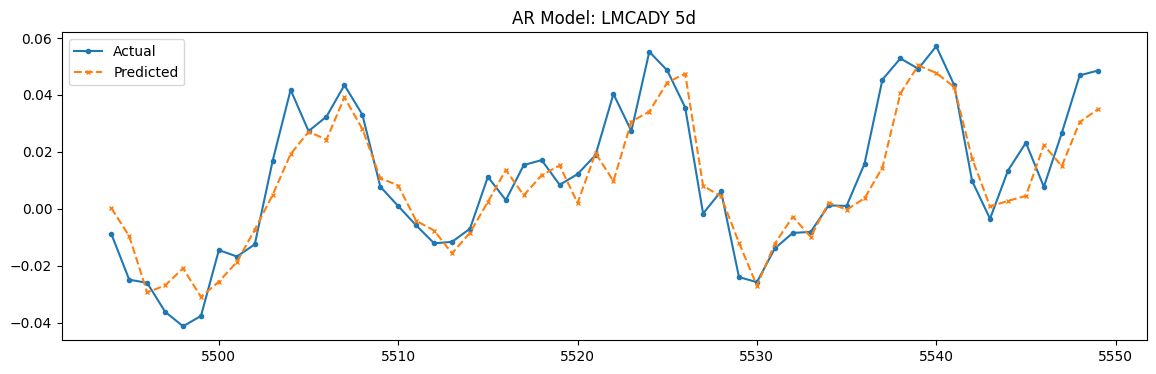

In [20]:
plot_predictions(LMCADY_test, best_predictions, "LMCADY {}d".format(window), markersize=3)